In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, norm
from statsmodels.stats.proportion import proportions_ztest
from multipy.fwer import holm_bonferroni
from utils import statistics, data_handler
import pickle

In [3]:
# data_path = './data/train'
# all_df = data_handler.load_data(data_path)

In [4]:
# all_df.to_pickle('./data/all_dfs_truncated.pkl')

# Loading concatenated df

In [5]:
all_df = pd.read_pickle('./data/all_dfs_truncated.pkl')

In [85]:
df = all_df.drop(columns=['Patient'])
not_nan_ratio = 1 - ((df.isna().sum().sum()) / (df.shape[0]*df.shape[1]))
print(f"Only {round(not_nan_ratio, 2)} of the data is not None")

Only 0.31 of the data is not None


# Notice there is a class imbalance

In [6]:
sepsis_labels = all_df.groupby('Patient').agg({'SepsisLabel': 'max'})['SepsisLabel']
sepsis_counter = sepsis_labels.sum()
n = sepsis_labels.count()

print(f'There are {sepsis_counter} patients with sepsis and {n-sepsis_counter} without')

There are 1415 patients with sepsis and 18585 without


In [7]:
len(all_df)

754817

In [8]:
stationary_cols = {'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'Patient'}
non_measure_cols = {'ICULOS', 'SepsisLabel'}
percent_cols = {'O2Sat', 'FiO2', 'SaO2', 'Hct'}


### Before truncation there were 766884

## Which features are available in the dataset + General Statistics per Column

In [9]:
data_stats = all_df.describe()
data_stats_t = data_stats.transpose()
data_stats_t['existing_data_ratio'] = np.around(data_stats_t['count']/len(all_df), 3)

stats = data_stats_t[['mean', 'std', 'min', 'max', 'existing_data_ratio']].sort_values('existing_data_ratio', ascending=False)
stats[['mean', 'std', 'existing_data_ratio']] = stats[['mean', 'std', 'existing_data_ratio']].round(2)
stats[['mean', 'std', 'existing_data_ratio']] = stats[['mean', 'std', 'existing_data_ratio']].round(2)


stats = stats.drop(['Patient'])
stats

mean     std      min      max  existing_data_ratio
Age                62.03   16.41    15.00   100.00                 1.00
SepsisLabel         0.00    0.04     0.00     1.00                 1.00
ICULOS             26.10   26.97     1.00   336.00                 1.00
HospAdmTime       -54.72  168.42 -5366.86    17.34                 1.00
Gender              0.56    0.50     0.00     1.00                 1.00
HR                 84.56   17.34    20.00   280.00                 0.90
MAP                82.34   16.28    20.00   300.00                 0.87
O2Sat              97.20    2.94    20.00   100.00                 0.87
SBP               123.55   23.13    20.00   299.00                 0.85
Resp               18.72    5.09     1.00   100.00                 0.84
DBP                63.82   13.90    20.00   300.00                 0.69
Unit1               0.49    0.50     0.00     1.00                 0.61
Unit2               0.51    0.50     0.00     1.00                 0.61
Temp               36.97    0.77    20.90    50.00                 0.34
Glucose           137.00   51.13    10.00   952.00                 0.17
Potassium           4.14    0.65     1.30    27.50                 0.09
Hct                30.83    5.50     8.80    71.70                 0.09
FiO2                0.59   16.12   -50.00  4000.00                 0.08
Hgb                10.44    1.97     2.60    25.00                 0.07
pH                  7.38    0.07     6.62     7.78                 0.07
BUN                23.41   19.63     1.00   268.00                 0.07
WBC                11.41    7.39     0.10   440.00                 0.06
Magnesium           2.05    0.40     0.60     9.80                 0.06
Creatinine          1.49    1.77     0.10    41.90                 0.06
Platelets         196.82  103.66     2.00  2322.00                 0.06
Calcium             7.56    2.43     1.00    27.90                 0.06
PaCO2              41.13    9.31    10.00   100.00                 0.06
BaseExcess         -0.77    4.29   -32.00    49.50                 0.05
Chloride          105.90    5.80    74.00   145.00                 0.04
HCO3               24.08    4.37     0.00    55.00                 0.04
Phosphate           3.54    1.41     0.30    17.60                 0.04
SaO2               92.49   11.06    26.00   100.00                 0.04
EtCO2              33.05    8.00    10.00   100.00                 0.04
PTT                41.23   26.46    17.10   250.00                 0.03
Lactate             2.68    2.54     0.20    31.00                 0.03
Alkalinephos      100.92  111.65     7.00  2528.00                 0.02
AST               263.16  879.11     5.00  9961.00                 0.02
Bilirubin_total     1.96    3.88     0.10    49.60                 0.01
TroponinI           8.23   24.67     0.01   440.00                 0.01
Fibrinogen        284.37  151.68    35.00  1760.00                 0.01
Bilirubin_direct    1.53    3.09     0.01    35.00                 0.00

### Fixing Values that do not make sense

#### Remove values that are more than 2 standard deviations from the mean

In [10]:
non_stationary_cols = [col for col in all_df.columns if col not in stationary_cols and col not in non_measure_cols]
low_cutoff_dict = dict(stats.loc[non_stationary_cols, 'mean'] - 2*stats.loc[non_stationary_cols, 'std'])
high_cutoff_dict = dict(stats.loc[non_stationary_cols, 'mean'] + 2*stats.loc[non_stationary_cols, 'std'])
hosp_adm_time_vec = all_df.groupby('Patient').max()['HospAdmTime']

low_cutoff_dict['HospAdmTime'] = hosp_adm_time_vec.mean() - 2*hosp_adm_time_vec.std()
high_cutoff_dict['HospAdmTime'] = hosp_adm_time_vec.mean() + 2*hosp_adm_time_vec.std()

#### In pecrent features, leave only values between 0 and 100

In [11]:
percent_cols = ['O2Sat', 'FiO2', 'SaO2', 'Hct']
for col in percent_cols:
    low_cutoff_dict[col] = max(low_cutoff_dict[col], 0)
    high_cutoff_dict[col] = min(high_cutoff_dict[col], 100)

In [12]:
with open('data/cutoff_dicts/low_cutoff.pkl', 'wb') as f:
    pickle.dump(low_cutoff_dict, f)
with open('data/cutoff_dicts/high_cutoff.pkl', 'wb') as f:
    pickle.dump(high_cutoff_dict, f)


In [13]:
all_df = data_handler.leave_only_reasonable_values(all_df)

In [14]:
data_stats = all_df.describe()
data_stats_t = data_stats.transpose()
data_stats_t['existing_data_ratio'] = np.around(data_stats_t['count']/len(all_df), 3)

stats = data_stats_t[['mean', 'std', 'min', 'max', 'existing_data_ratio']].sort_values('existing_data_ratio', ascending=False)
stats[['mean', 'std', 'existing_data_ratio']] = stats[['mean', 'std', 'existing_data_ratio']].round(2)
stats[['mean', 'std', 'existing_data_ratio']] = stats[['mean', 'std', 'existing_data_ratio']].round(2)


stats = stats.drop(['Patient'])
stats

mean     std     min      max  existing_data_ratio
Age                62.03   16.41   15.00   100.00                 1.00
SepsisLabel         0.00    0.04    0.00     1.00                 1.00
ICULOS             26.10   26.97    1.00   336.00                 1.00
Gender              0.56    0.50    0.00     1.00                 1.00
HospAdmTime       -34.47   61.62 -331.03    17.34                 0.97
HR                 83.47   15.16   50.00   119.00                 0.86
O2Sat              97.47    2.21   91.50   100.00                 0.84
MAP                80.90   13.59   49.83   114.83                 0.84
SBP               121.71   20.06   77.50   169.75                 0.82
Resp               18.25    4.10    8.75    28.75                 0.81
DBP                62.63   11.54   36.25    91.50                 0.66
Unit1               0.49    0.50    0.00     1.00                 0.61
Unit2               0.51    0.50    0.00     1.00                 0.61
Temp               36.98    0.65   35.44    38.50                 0.33
Glucose           129.83   34.80   35.00   239.00                 0.16
Potassium           4.08    0.50    2.85     5.43                 0.09
Hct                30.49    4.72   19.85    41.80                 0.08
FiO2                0.53    0.19    0.00     7.00                 0.08
Hgb                10.31    1.72    6.50    14.30                 0.07
pH                  7.38    0.06    7.24     7.52                 0.07
BUN                20.04   12.37    1.00    62.00                 0.06
WBC                10.82    4.56    0.10    26.10                 0.06
Magnesium           2.02    0.30    1.25     2.80                 0.06
Creatinine          1.16    0.80    0.10     5.03                 0.06
Platelets         184.38   79.41    2.00   404.00                 0.06
PaCO2              40.07    6.74   22.80    59.50                 0.05
Calcium             8.29    0.89    2.70    12.40                 0.05
BaseExcess         -0.75    3.17   -9.20     7.60                 0.05
Chloride          106.04    4.71   94.50   117.00                 0.04
HCO3               24.04    3.39   15.70    32.40                 0.04
Phosphate           3.35    1.05    0.80     6.30                 0.04
EtCO2              33.34    6.50   17.50    49.00                 0.03
SaO2               95.37    5.55   70.50   100.00                 0.03
PTT                36.49   13.99   17.10    94.10                 0.03
Lactate             2.24    1.41    0.20     7.76                 0.02
Alkalinephos       85.89   50.75    7.00   324.00                 0.02
AST               130.68  267.13    5.00  2019.00                 0.02
Bilirubin_total     1.34    1.51    0.10     9.70                 0.01
TroponinI           4.64   10.02    0.01    57.34                 0.01
Fibrinogen        260.56  111.78   35.00   587.00                 0.01
Bilirubin_direct    1.10    1.50    0.01     7.50                 0.00

<ipython-input-32-2287342f51b5>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


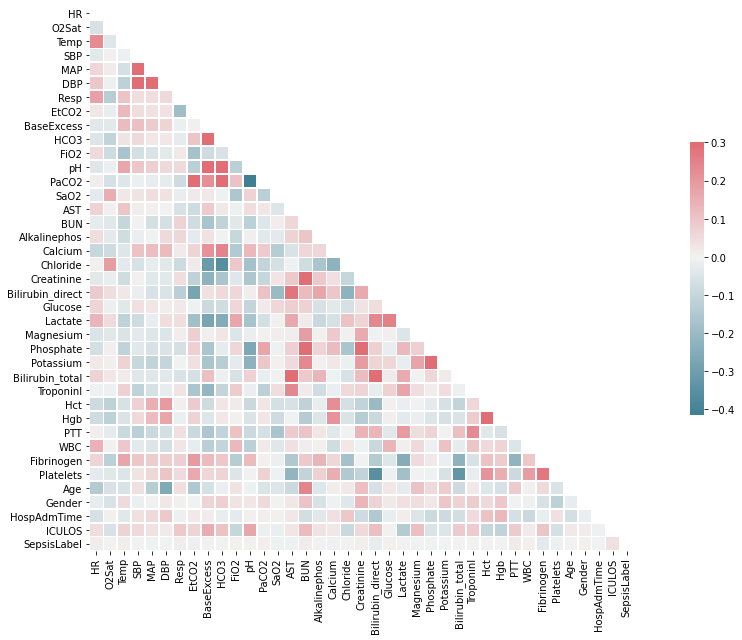

In [32]:
#look at feature correlations
corr = all_df.drop(columns=['Unit1', 'Unit2', 'Patient']).corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#make the heatmap plot
plt.figure(figsize=(16,9))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()
plt.show()

**Checking if there is a change in ICU unit of a patient during its stay:**

In [16]:
t = all_df.fillna(-1)
t = t[['Unit1', 'Patient']].groupby('Patient').mean()
t['Unit1'].unique()

array([ 0., -1.,  1.])

In [17]:
t = all_df.fillna(-1)
t = t[['Unit2', 'Patient']].groupby('Patient').mean()
t['Unit2'].unique()

array([ 1., -1.,  0.])

### As we can see, there are no values between -1 and 0 or 0 and 1, meaning each patient is assigned to an ICU unit once (or unknown if NaN)

**Creating an aggregated dataframe to represent each patient with only one record. This is in order to find distribution among the ill patients (with sepsis) and not creating any bias since they have reapeted records after being marked once.**

In [18]:
nan_threshold = 0.9
to_scatter_columns = [col for col, row in data_stats_t.iterrows() if 1 - row['existing_data_ratio'] < nan_threshold and col not in stationary_cols]
to_scatter_columns.remove('SepsisLabel')
to_scatter_columns.remove('ICULOS')
# to_scatter_columns

In [34]:
agg_dict = {col: 'mean' for col in all_df.columns}
agg_dict['ICULOS'] = 'max'
agg_dict['Gender'] = 'max'
agg_dict['SepsisLabel'] = 'max'
agg_dict['Unit1'] = 'max'
agg_dict['Unit2'] = 'max'

mean_df = all_df.groupby('Patient').agg(agg_dict)


## Histogram per SepsisLabel for the binary features

In [60]:
t.sum()

SepsisLabel    0.063099
dtype: float64

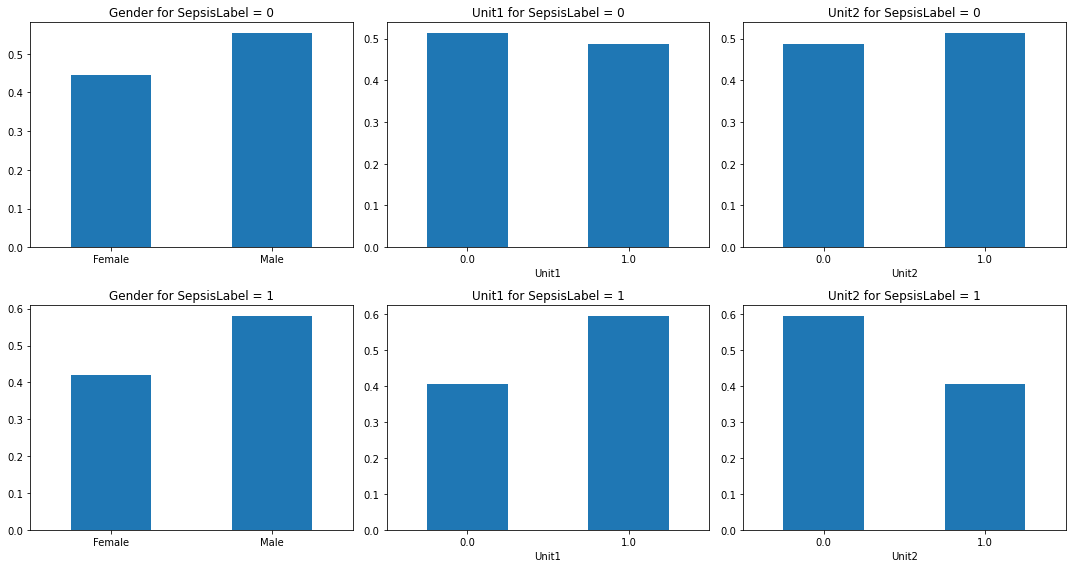

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
fig.tight_layout()
for i, sepsis_label in enumerate([0., 1.]):
    for j, col in enumerate(['Gender', 'Unit1', 'Unit2']):
        col_idx = j    
        t = mean_df[mean_df['SepsisLabel'] == sepsis_label][[col, 'SepsisLabel']].groupby(col).count()
        t = t / t.sum()
        if col_idx == 0:
            t.index = ['Female', 'Male']

        t.plot.bar(ax=axes[i, col_idx], rot=0)
        axes[i, col_idx].set_title(f'{col} for SepsisLabel = {i}')
        axes[i, col_idx].get_legend().remove()
plt.tight_layout()

**It looks like there is a relation between the odds of a patient having sepsis and the ICU unit he is in.** \
As we can see, there is a big gap between unit 1 and unit 2 for patients with sepsis (Unit1 = 1, the indicator for being in unit 1 with sepsis=1 is 1.51 times). \
Since we saw before that there is no change in ICU assignment of a patient, it might give us an indication about why patients are developing sepsis, i.e. checking why a patient is assigned to any of those units might help us predict sepsis.

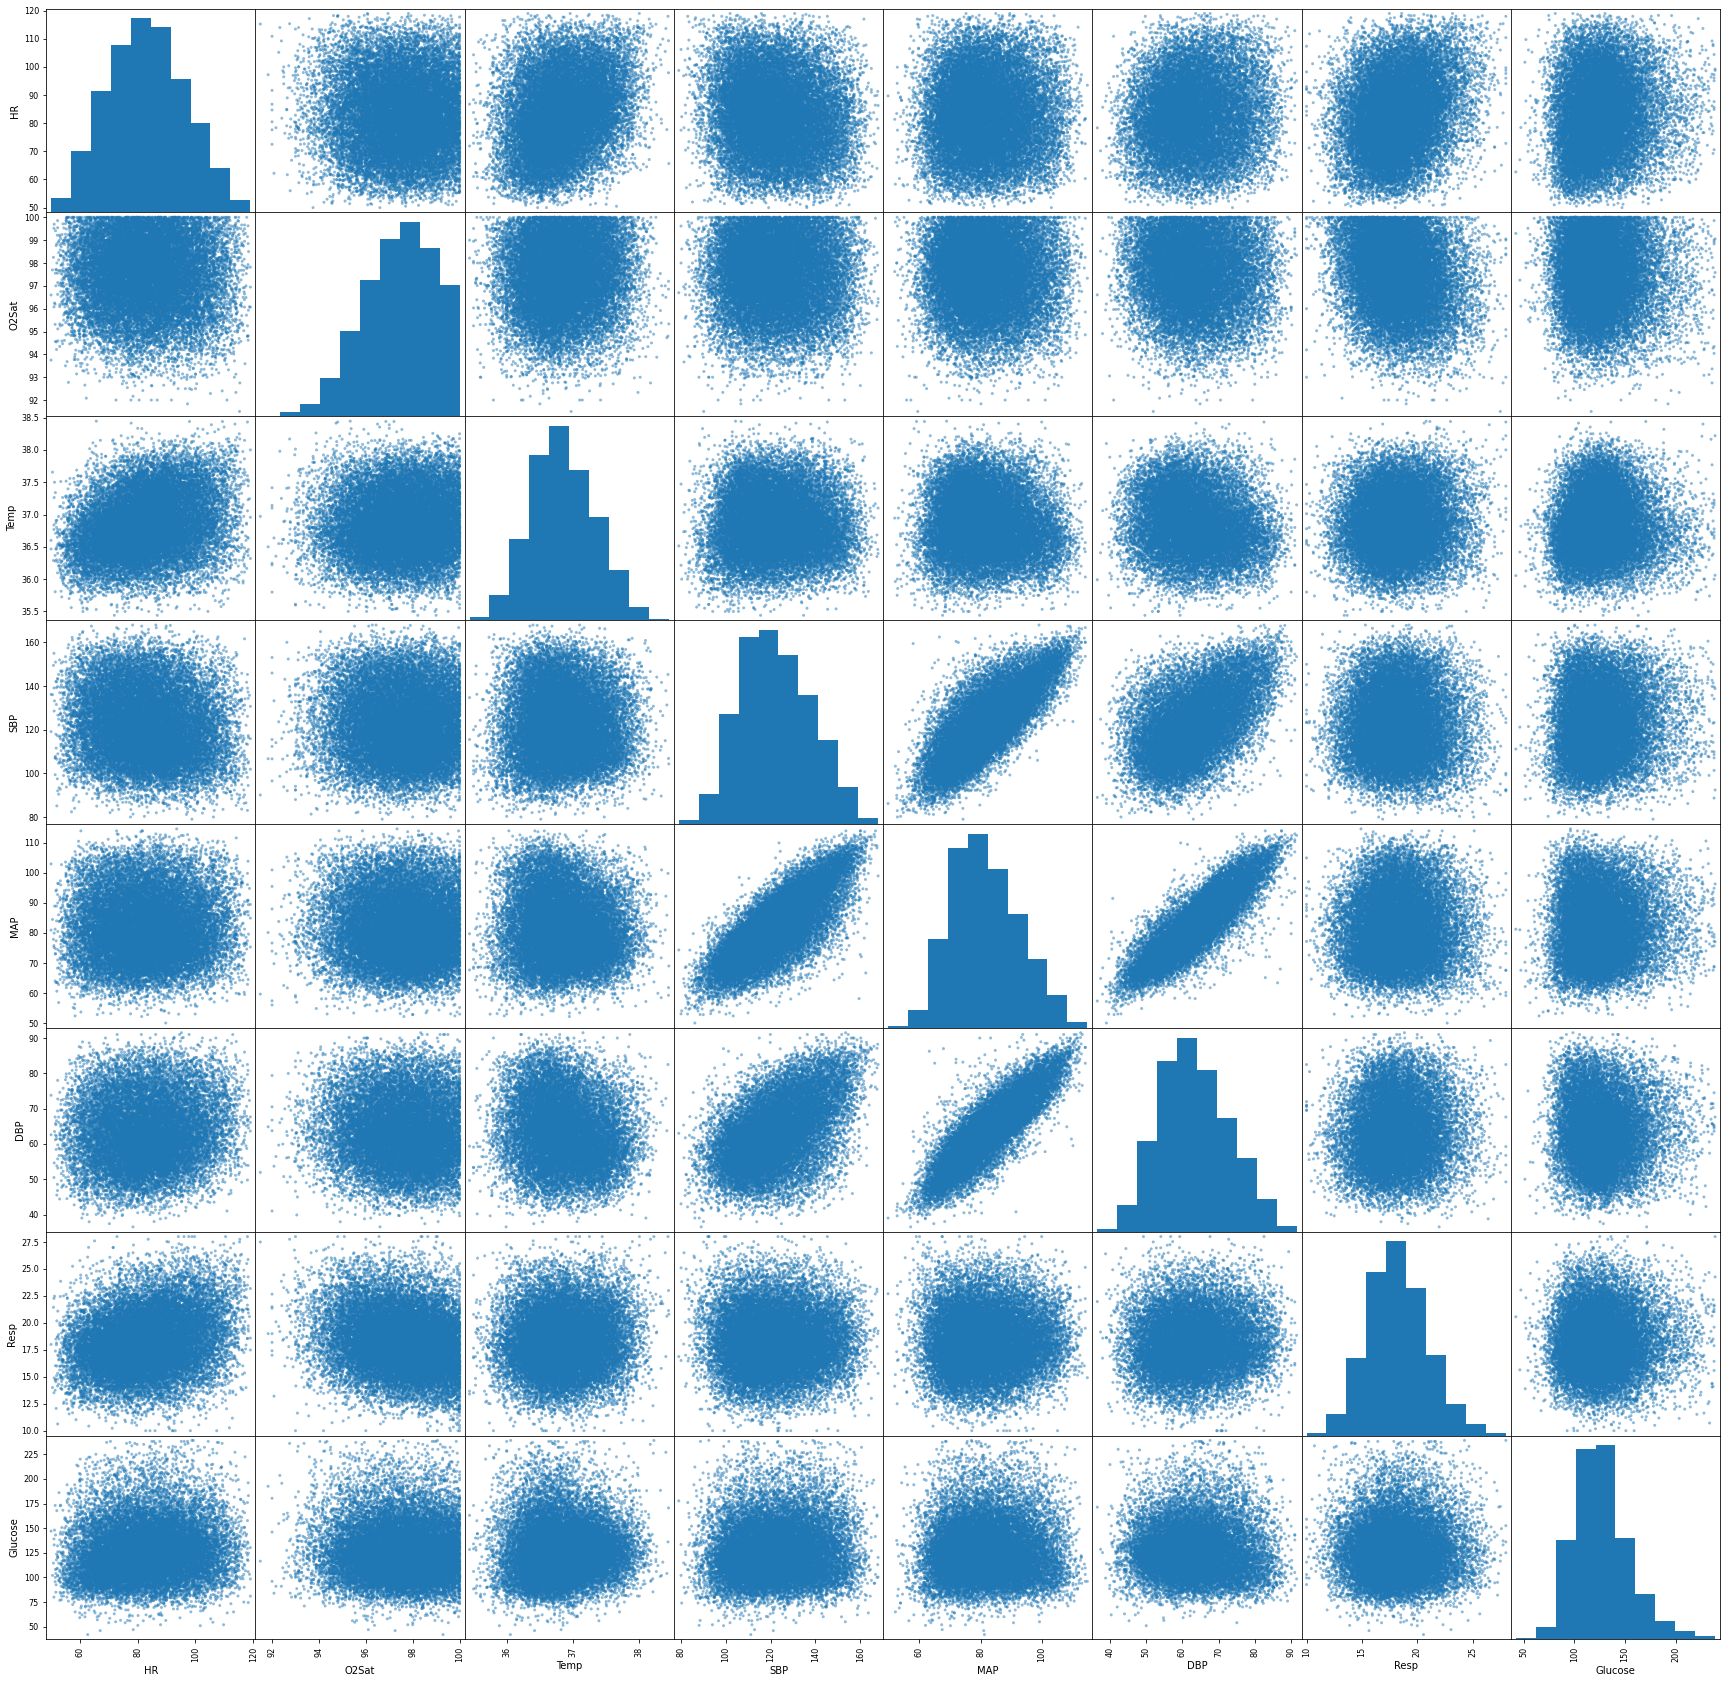

In [36]:
pd.plotting.scatter_matrix(mean_df[to_scatter_columns], figsize=(30,30));

## Histogram per Feature

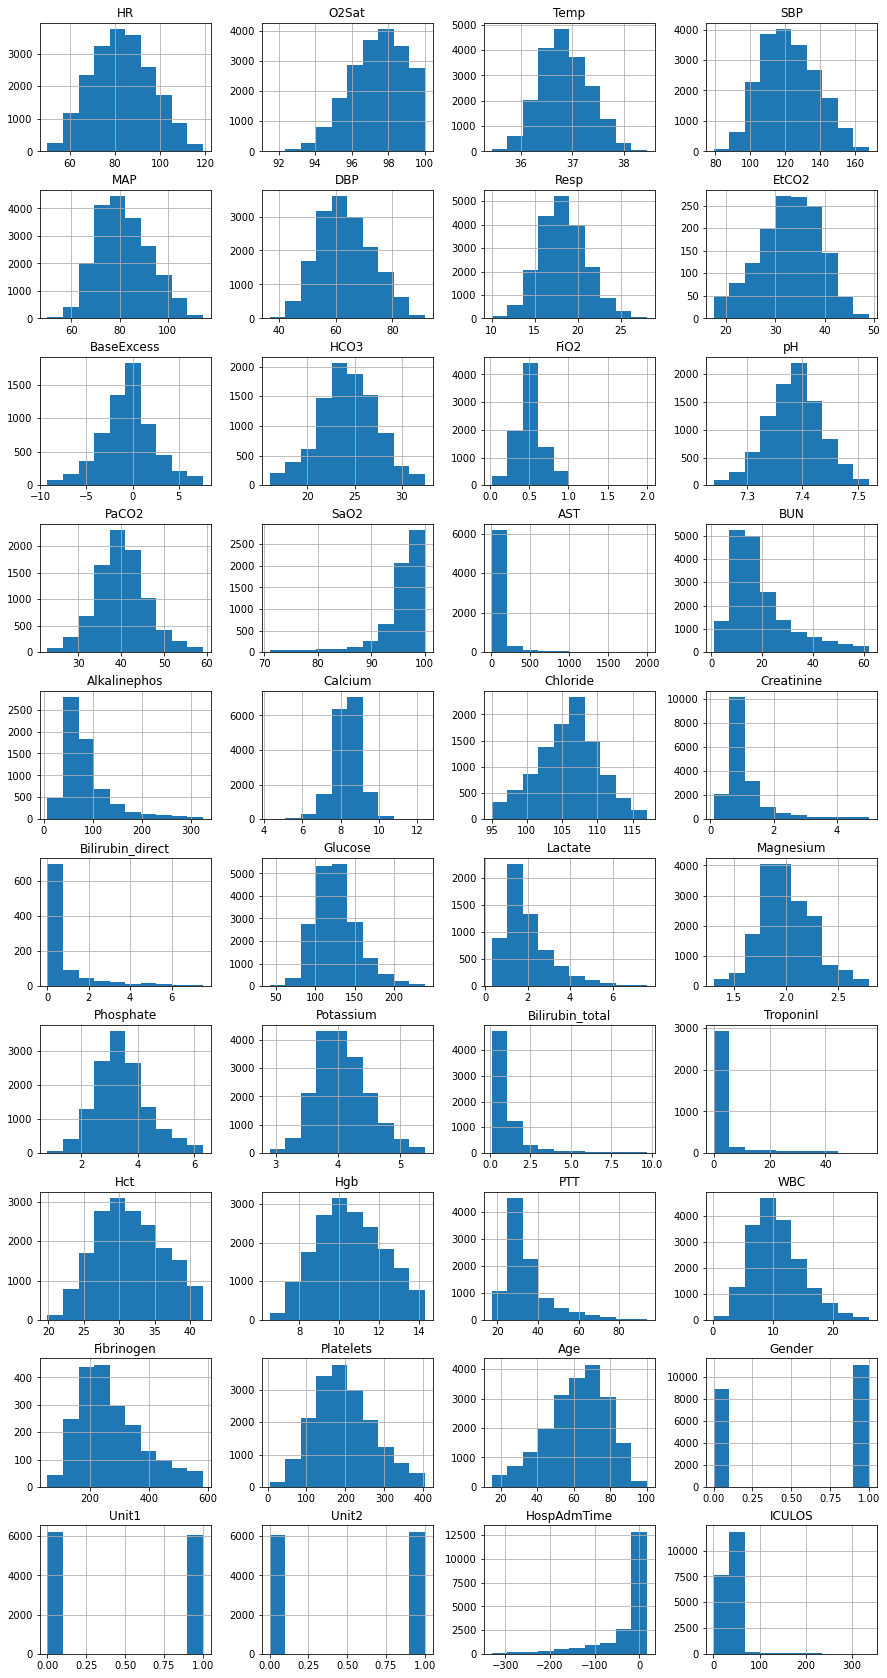

In [37]:
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(15, 30))
mean_df.drop(columns=['SepsisLabel', 'Patient']).hist(ax=axes);

**We will plot all features again with log-scale to y axis in order to gain better understanding of the distribution of continuos features.**

In [63]:
# fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(15, 30))
# for row in axes:
#     for ax in row:
#         ax.set_yscale('log')
# mean_df.drop(columns=['SepsisLabel', 'Patient']).hist(ax=axes);

## Boxplots of features values according to SepsisLabel

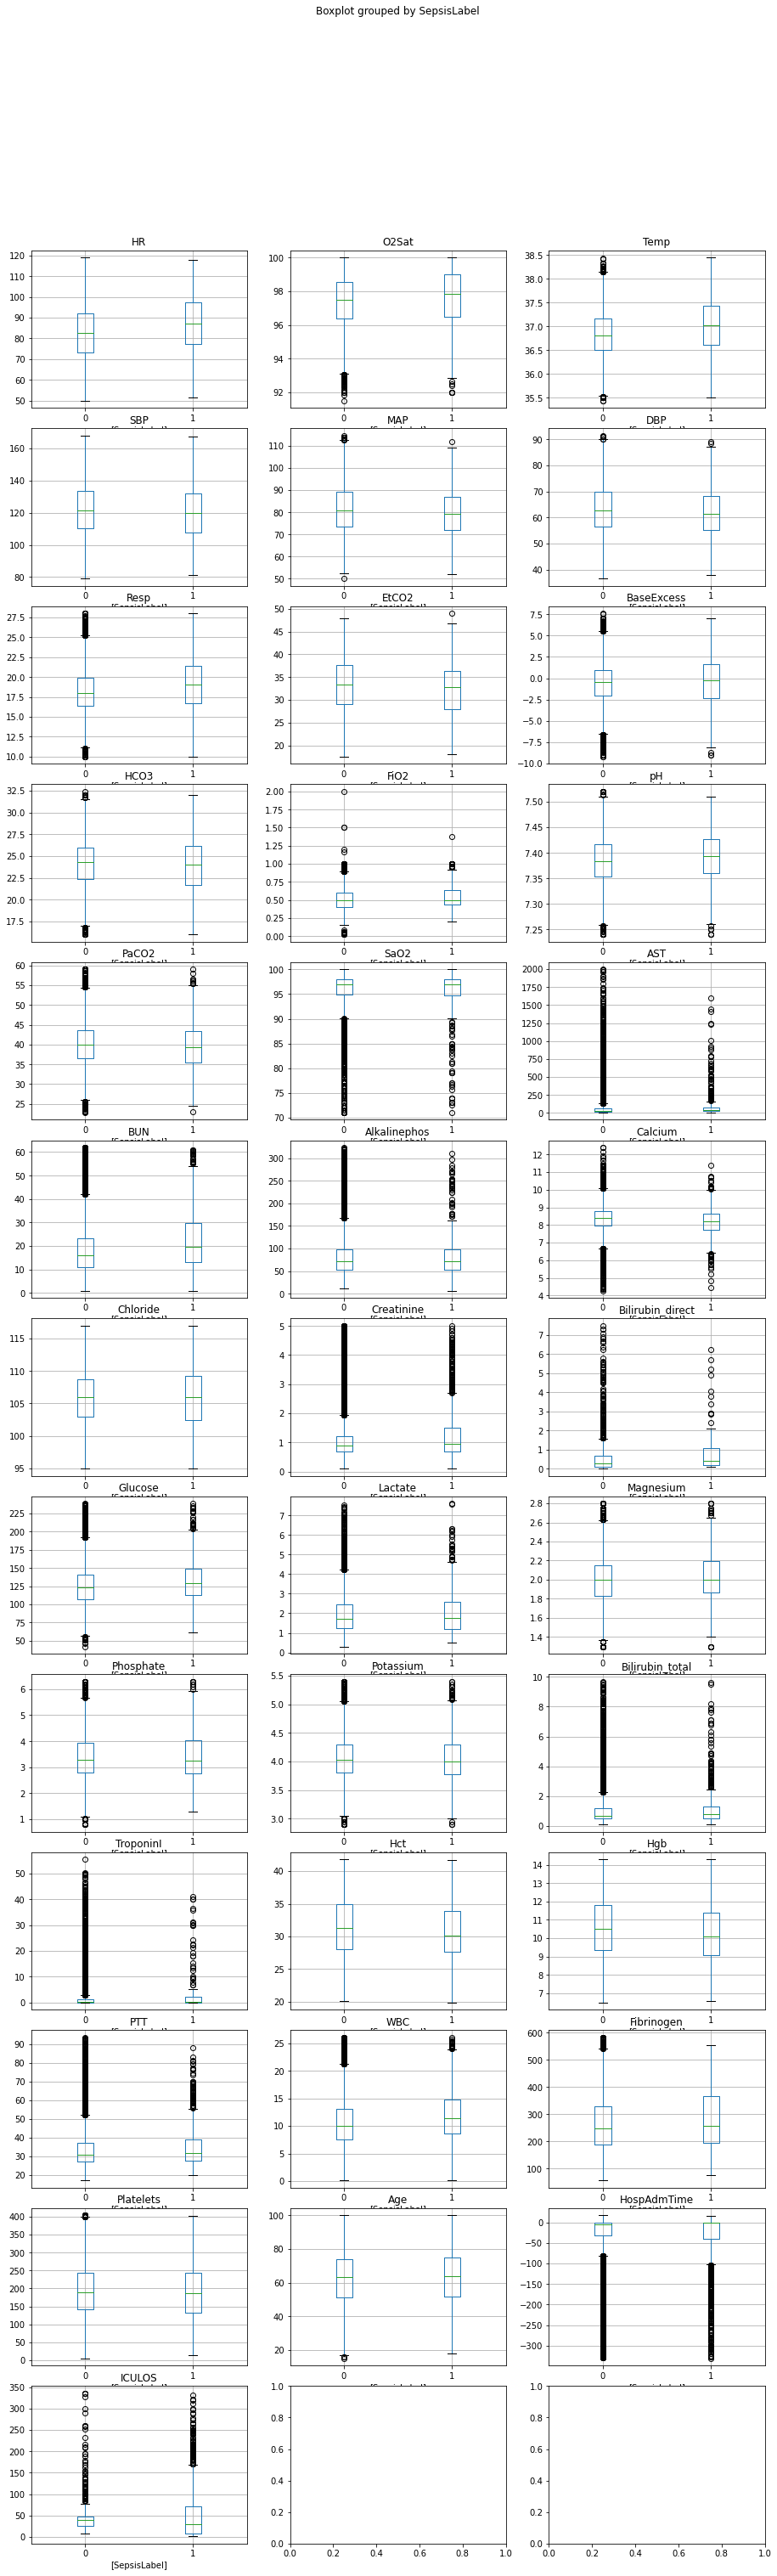

In [39]:
fig, axes = plt.subplots(nrows=13, ncols=3, figsize=(15,50))
cols = list(all_df.columns)
fig.tight_layout()
cols.remove('SepsisLabel')
cols.remove('Patient')
# Removing binary columns since boxplot is not indicative for it.
cols.remove('Unit1')
cols.remove('Unit2')
cols.remove('Gender')

for i, col in enumerate(cols):
    row_idx = int(np.floor(i/3))
    col_idx = i%3
    mean_df[[col,'SepsisLabel']].boxplot(by='SepsisLabel', ax=axes[row_idx, col_idx])

## Digging deeper into interesting features:
* Resp
* BaseExcess
* HCO3
* Fi02
* BUN
* PaC02
* Calcium
* Magnesium
* Lactate
* Bilirubin direct
* PTT
* Age
* Platelets
* Fibrinogen
* ICULOS
* HospAdmTime
* unit 1
* unit 2

## Mann-Whitney U Test

In [41]:
statistics.check_feature_label_dependency_mannwhitneyu(mean_df, alpha=0.05)

col   pval  With Sepsis Size  No Sepsis Size  \
2               Temp  0.000              1159           18447   
0                 HR  0.000              1228           18552   
6               Resp  0.000              1217           18538   
15               BUN  0.000              1001           17153   
31               WBC  0.000              1022           17263   
17           Calcium  0.000              1000           15986   
35       HospAdmTime  0.000              1332           18066   
21           Glucose  0.000              1086           17786   
36            ICULOS  0.000              1415           18585   
28               Hct  0.000              1041           16855   
29               Hgb  0.000              1029           16926   
1              O2Sat  0.000              1231           18551   
19        Creatinine  0.000               999           17008   
4                MAP  0.000              1235           18514   
5                DBP  0.000               999           15228   
10              FiO2  0.000               851            7778   
14               AST  0.000               557            6267   
11                pH  0.000               832            8217   
3                SBP  0.000              1167           18492   
20  Bilirubin_direct  0.001                99             839   
23         Magnesium  0.001               996           16076   
9               HCO3  0.001               675            8848   
27         TroponinI  0.001               174            3264   
12             PaCO2  0.003               815            7857   
26   Bilirubin_total  0.003               545            6178   
30               PTT  0.005               751            8933   
7              EtCO2  0.036               174            1266   
25         Potassium  0.045              1060           17641   
32        Fibrinogen  0.055               196            1860   
33         Platelets  0.061               993           16879   
34               Age  0.068              1415           18585   
8         BaseExcess  0.096               611            5657   
22           Lactate  0.200               668            5252   
18          Chloride  0.206               736            9436   
16      Alkalinephos  0.255               542            6075   
24         Phosphate  0.376               885           12554   
13              SaO2  0.474               522            5684   

    rejected_h0_multiple_comparison  
2                              True  
0                              True  
6                              True  
15                             True  
31                             True  
17                             True  
35                             True  
21                             True  
36                             True  
28                             True  
29                             True  
1                              True  
19                             True  
4                              True  
5                              True  
10                             True  
14                             True  
11                             True  
3                              True  
20                             True  
23                             True  
9                              True  
27                             True  
12                             True  
26                             True  
30                            False  
7                             False  
25                            False  
32                            False  
33                            False  
34                            False  
8                             False  
22                            False  
18                            False  
16                            False  
24                            False  
13                            False

## Wald Test

In [43]:
statistics.check_feature_label_dependency_wald(mean_df, alpha=0.05)

col   pval  With Sepsis Size  No Sepsis Size  \
0                 HR  0.000              1228           18552   
2               Temp  0.000              1159           18447   
6               Resp  0.000              1217           18538   
31               WBC  0.000              1022           17263   
36            ICULOS  0.000              1415           18585   
15               BUN  0.000              1001           17153   
17           Calcium  0.000              1000           15986   
21           Glucose  0.000              1086           17786   
19        Creatinine  0.000               999           17008   
28               Hct  0.000              1041           16855   
4                MAP  0.000              1235           18514   
29               Hgb  0.000              1029           16926   
10              FiO2  0.000               851            7778   
5                DBP  0.000               999           15228   
3                SBP  0.000              1167           18492   
1              O2Sat  0.000              1231           18551   
23         Magnesium  0.002               996           16076   
11                pH  0.002               832            8217   
9               HCO3  0.002               675            8848   
26   Bilirubin_total  0.004               545            6178   
35       HospAdmTime  0.005              1332           18066   
12             PaCO2  0.017               815            7857   
30               PTT  0.018               751            8933   
32        Fibrinogen  0.066               196            1860   
7              EtCO2  0.072               174            1266   
33         Platelets  0.123               993           16879   
34               Age  0.170              1415           18585   
25         Potassium  0.208              1060           17641   
20  Bilirubin_direct  0.234                99             839   
18          Chloride  0.339               736            9436   
22           Lactate  0.354               668            5252   
27         TroponinI  0.378               174            3264   
8         BaseExcess  0.405               611            5657   
24         Phosphate  0.486               885           12554   
14               AST  0.519               557            6267   
13              SaO2  0.557               522            5684   
16      Alkalinephos  0.573               542            6075   

    rejected_h0_multiple_comparison  
0                              True  
2                              True  
6                              True  
31                             True  
36                             True  
15                             True  
17                             True  
21                             True  
19                             True  
28                             True  
4                              True  
29                             True  
10                             True  
5                              True  
3                              True  
1                              True  
23                             True  
11                             True  
9                              True  
26                            False  
35                            False  
12                            False  
30                            False  
32                            False  
7                             False  
33                            False  
34                            False  
25                            False  
20                            False  
18                            False  
22                            False  
27                            False  
8                             False  
24                            False  
14                            False  
13                            False  
16                            False

## Proportion Test for Binary Variables

### Bootstrap


In [44]:
statistics.check_categorical_feature_label_dependency_bootstrap(mean_df, alpha=0.05, B=10, seed=42)

col  pval  With Sepsis Size  rejected_h0_multiple_comparison
0   Unit1   0.0               777                             True
1   Unit2   0.0               777                             True
2  Gender   0.0              1415                             True

In [45]:
for col in ['Unit1', 'Unit2', 'Gender']:
    col_no_sepsis = mean_df[mean_df['SepsisLabel'] == 0][col].dropna().to_numpy()
    col_with_sepsis = mean_df[mean_df['SepsisLabel'] == 1][col].dropna().to_numpy()
    print(f'{col} : with sepsis mean: {np.around(col_with_sepsis.mean(),3)}, no sepsis mean: {np.around(col_no_sepsis.mean(), 3)}')

Unit1 : with sepsis mean: 0.595, no sepsis mean: 0.487
Unit2 : with sepsis mean: 0.405, no sepsis mean: 0.513
Gender : with sepsis mean: 0.581, no sepsis mean: 0.554


# Conclusions

* We used sampling from the features w/o sepsis in order to balance the sizes of w/ sepsis and w/o so that the statistical test would be more informative.
* We used bootstrap in order to reduce the variance of the p-values since there are many ways to sample from a large set.
* As we can see from the hypothesis tests over the continous variables:
    * Using U-test we see that there is no statistical significance of the distributions of features among the patients w/ sepsis and w/o.
    * Using Wald test, we can see the same for the mean of each feature among the patients w/ sepsis and w/o.
* Applying the proportion test for the binary features yields a statistical significance for the difference between means at each binary feautre, e.g. there is a difference between men and women which are diagnosed w/ or w/o sepsis.